# MiniGato

From the paper [A Generalist Agent](https://arxiv.org/abs/2205.06175).

The paper doesn't introduce a new architecture. Instead, the paper is all about tokenizing, embedding, and sequencing data from multiple modalities (text, image, proprioception) in such a way that it can be learned by a transformer.

Reproducing the paper is more of a software design exercise than an ML research exercise. How would you structure the data manipulation code – the tokenization, embedding, and sequencing of different modalities – in a way that's correct, easy to understand and extend, and performant?

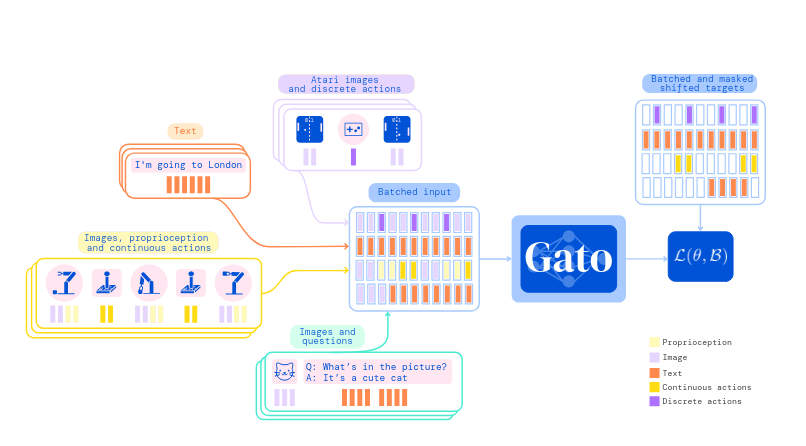

### Imports

In [500]:
from abc import ABC, abstractmethod
from collections import defaultdict, OrderedDict as DefaultOrderedDict
from itertools import cycle
import math
import os
from pathlib import Path
import pdb
import random
import re
import tempfile
from typing import List, Protocol
from dataclasses import dataclass, fields
import datasets
from einops import rearrange
from functools import partial
from mini_gato.nano_gpt import GPT, GPTConfig
import numpy as np
import matplotlib.pyplot as plt
import minari
from mini_gato.util import (
    tensor_as_gif, TransformDataset,
    images_to_patches, patches_to_images, normalize_to_between_minus_one_plus_one,
    apply_along_dimension, discretize, undiscretize,
    interleave, deinterleave,
)
import minigrid.core
import requests
from timm.models.resnetv2 import ResNetV2
import tiktoken
import torch
import torch.nn.functional as F
import torchvision.transforms.v2 as transforms
from torchvision.transforms.functional import pil_to_tensor
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

## Tokenization [§ 2.1](https://arxiv.org/pdf/2205.06175)

> There are infinite possible ways to transform data into tokens, including directly using the raw underlying byte stream.

Some of this notebook deviates slightly (insignificantly, I expect) from the Gato paper.

- Text is encoded via `tiktoken`'s [r50k_base](https://github.com/openai/tiktoken/blob/63527649963def8c759b0f91f2eb69a40934e468/tiktoken_ext/openai_public.py#L33)
- Images are transformed into sequences of non-overlapping 16x16 patches in raster order, as done in [ViT (Dosovitskiy et al., 2020)](https://arxiv.org/pdf/2010.11929).
- Discrete values, e.g. Atari button presses, are flattened into sequences of integers within the range [50257, 51280) – the 1023 tokens after the text tokenizer's range. Discrete token 51281 (the 1024th discrete token) is used as the separator token between an observation and an action.
- Continuous values, e.g. proprioceptive inputs or joint torques, are first flattened into sequences of floating point values, then mu-law encoded to the range [-1, 1], then discretized into 1024 uniform bins, then encoded the same as discrete values.
- Discrete observations that represent a grid-like environment (i.e. [Minigrid](https://minigrid.farama.org/environments/minigrid/)) are transformed into images and encoded as such. This might be the most significant change. The Gato paper describes flattening these types of discrete observation values. That loses the benefit of neighboring column/row patch position encoding of images. Plus this is extra image training data for free.

In [2]:
text_tokenizer = tiktoken.get_encoding("r50k_base")
text_tokenizer.encode("foobar"), text_tokenizer.eot_token

([6513, 30973], 50256)

In [3]:
class TextTokenizer(Protocol):
    n_vocab: int
    eot_token: int
    def encode(self, text: str) -> List[int]:
        ...
    def decode(self, tokens: List[int]) -> str:
        ...

class Tokenizer:
    def __init__(self, text_tokenizer: TextTokenizer):
        self.text_tokenizer = text_tokenizer
        self.eot_token = text_tokenizer.eot_token
        self.n_text = text_tokenizer.n_vocab
        self.n_discrete = 1024
        self.boa_token = 1023  # Separator between observation and action.
        self.vocab_size = self.n_text + self.n_discrete

    # It's useful to know if a tensor of tokens is of a particular modality – text, image, discrete, etc...
    #
    # Why?
    #
    # Embedding, for example. Images get embedded with a ResNetV2 block. Text and
    # discrete get embedded with an nn.Embedding lookup table.
    #
    # We can tell what modality something is by simply checking the range of its tokens.
    # Text is in the range [0, 50256) for the tiktoken tokenizer.
    # Discrete and continuous are in the range [50257, 51281) – the 1024 tokens after vocab.
    # Images are floats and have a different shape because they get patched.
    def is_text(self, tokens: torch.Tensor) -> bool:
        return 0 <= tokens[0, 0, 0] < self.n_text

    def is_discrete(self, tokens: torch.Tensor) -> bool:
        return self.n_text <= tokens[0, 0, 0] < self.n_text + self.n_discrete

    def is_image(self, tokens: torch.Tensor) -> bool:
        return tokens.size(-1) > 1  # Images are the only modality that have a channel dim > 1.

    def encode_text(self, text: str) -> torch.Tensor:
        tokens = torch.tensor([self.eot_token, *self.text_tokenizer.encode(text), self.eot_token]).reshape(1, -1, 1)
        return tokens

    def decode_text(self, tokens: torch.Tensor) -> str:
        return self.text_tokenizer.decode(tokens.squeeze()[1:-1].tolist())
        
    def encode_discrete(self, tokens: List[int], is_action=False) -> torch.Tensor:
        if is_action:
            #                                                -1   +      n_text == eot_token
            tokens = (torch.tensor([self.boa_token, *tokens, -1]) + self.n_text).reshape(1, -1, 1)
        else:
            tokens = (torch.tensor([-1, *tokens, -1]) + self.n_text).reshape(1, -1, 1)
        return tokens
        
    def decode_discrete(self, tokens: torch.Tensor) -> List[int]:
        return (tokens - self.n_text).squeeze()[1:-1].tolist()

    # TODO:
    # The paper says to mu-law encode continuous values.
    # We're not doing that yet.
    def encode_continuous(self, tokens: List[float], is_action=False) -> torch.Tensor:
        if is_action:
            tokens = (discretize(torch.tensor([self.boa_token, *tokens, -1])) + self.n_text).reshape(1, -1, 1)
        else:
            tokens = (discretize(torch.tensor([-1, *tokens, -1])) + self.n_text).reshape(1, -1, 1)
        return tokens

    # This is going to be a lossy decode. The paper says to clip companded values so that
    # they fall within the range [-1, 1]. The paper says actions are only defined in the range [-1, 1]
    # for all of their environments, so it doesn't hurt in practice. But if you expect to be able
    # to compand/uncompand, you'll be disappointed.
    def decode_continuous(self, tokens: torch.Tensor) -> List[float]:
        return undiscretize((tokens - self.n_text).squeeze()[1:]).tolist()

    def encode_image(self, image, patch_size=16):
        patches = images_to_patches(image, patch_size=patch_size)
        xs = (
            apply_along_dimension(
                normalize_to_between_minus_one_plus_one, 1, patches
            )
            / math.sqrt(patch_size)
        )        
        return xs.unsqueeze(0)
    
    def decode_image(self, tokens, image_shape=(3, 192, 192), patch_size=16):
        # Lossy because I'm not saving the values used for scaling from encoding.
        patches = (tokens * math.sqrt(patch_size) + 1) / 2
        images = patches_to_images(patches, image_shape, patch_size=patch_size)
        return images        

#### Examples

In [4]:
x = torch.arange(-2, 5) * 1.5
x, discretize(x), undiscretize(discretize(x), x.min(), x.max())

(tensor([-3.0000, -1.5000,  0.0000,  1.5000,  3.0000,  4.5000,  6.0000]),
 tensor([   0,  171,  342,  512,  682,  853, 1023]),
 tensor([-2.9956, -1.4927,  0.0103,  1.5044,  2.9985,  4.5015,  5.9956]))

Think about how you would tokenize and batch the examples below?

Keep in mind: samples might have different numbers of episodes and different numbers of tokens for a given key ('mission', 'image', 'action', etc...)

- One sample might have 19 episodes with a mission of "reach the goal".
- Another sample might have 12 episodes with a mission of "find the green key".
- Another might have 17 episodes where the first 10 have a mission of "find the green key" and the last 7 have a mission of "exit through the green door".

All of that means you're going to have to pad along several different dimensions.

Note that we can't stack these until both pad _and_ embed.

In [5]:
examples = [
    {
        # Continuous/Discrete/Text looks like this:
        #
        #                                 Episodes
        #                                 |  Tokens
        #                                 |  |  Channels
        #                                 |  |  |
        'mission': torch.arange(2*3).view(2, 3, 1),
        # Images look like this:
        #
        #                                  Episodes
        #                                  |  Height
        #                                  |  |  Width
        #                                  |  |  |  Channels
        #                                  |  |  |  |
        'image': torch.randn(2*7*7*3).view(2, 7, 7, 3),
        'action': torch.arange(2*1).view(2, 1, 1),
    },
    {
        'mission': torch.arange(3*4).view(3, 4, 1),
        'image': torch.randn(2*7*7*3).view(2, 7, 7, 3),
        'action': torch.arange(3*1).view(3, 1, 1),
    },
]

In [6]:
tokenizer = Tokenizer(text_tokenizer)

In [7]:
tokens = tokenizer.encode_text("Hello, world!")
tokens.shape, tokens

(torch.Size([1, 6, 1]),
 tensor([[[50256],
          [15496],
          [   11],
          [  995],
          [    0],
          [50256]]]))

In [8]:
tokenizer.decode_text(tokens)

'Hello, world!'

In [9]:
tokens = tokenizer.encode_discrete([0, 1, 2, 3], True)
tokens.shape, tokens

(torch.Size([1, 6, 1]),
 tensor([[[51280],
          [50257],
          [50258],
          [50259],
          [50260],
          [50256]]]))

In [10]:
tokenizer.decode_discrete(tokens)

[0, 1, 2, 3]

## Image prep

In [11]:
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
denormalize = transforms.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.255], [1/0.229, 1/0.224, 1/0.225])

In [12]:
image_transform = transforms.Compose([
    transforms.ToDtype(torch.float32, scale=True),
    transforms.RandomResizedCrop((192, 192), (1.0, 1.0)),
    normalize,
])

## Padding and slicing to fit context window

In [13]:
SEQUENCE_LENGTH = 1024

#### A brief note on sequencing

Take a look at an example agent dataset: [Four Rooms](https://minigrid.farama.org/environments/minigrid/FourRoomsEnv/).

You've got an observation space of `[mission, direction, image]`.

In [501]:
class OrderedDict(DefaultOrderedDict):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.device = 'cpu'
    def to(self, device):
        self.device = device
        result = OrderedDict()
        for k, v in self.items():
            result[k] = v.to(device)
        return result

In [15]:
# These next 5 functions are helpers for when we need have a sample with
# a large number of episodes and creating a sequence from all of them would
# be larger than our context window.
#
# These helpers pick a random index for an episode from the sample
# and then slice up to the greatest index that's within our max sequence length.

def episode_num_tokens(sample):
    return sum([len(v[0]) for v in sample.values()])

def sample_num_tokens(sample):
    return episode_num_tokens(sample) * next(iter(sample.values())).size(0)

def sequence_episode_capacity(sequence_length, sample):
    return sequence_length // episode_num_tokens(sample)

def random_episode_start_index(sequence_length, sample):
    n_eps = next(iter(sample.values())).size(0)
    cap = min(n_eps, sequence_episode_capacity(sequence_length, sample))
    return random.randint(0, n_eps - cap)

def slice_to_context_window(sequence_length, sample):
    result = OrderedDict()
    n = random_episode_start_index(1024, sample)
    m = sequence_episode_capacity(1024, sample)
    if m < 1:
        for k in sample.keys():
            result[k] = sample[k][:, :sequence_length]
    else:
        for k in sample.keys():
            result[k] = sample[k][n:n+m]
    return result

In [16]:
sample = OrderedDict(text=torch.arange(50 * 100).view(50, -1, 1))
random_episode_start_index(1024, sample), sequence_episode_capacity(1024, sample)

(13, 10)

In [17]:
sample = OrderedDict(text=torch.arange(1025).view(1, -1, 1))
random_episode_start_index(1024, sample), sequence_episode_capacity(1024, sample)

(0, 0)

In [18]:
slice_to_context_window(1024, sample)['text'].shape

torch.Size([1, 1024, 1])

In [19]:
# There's a hidden depency in all of this code that `batch` is an OrderedDict.
# The order of the keys is the order we'll use to create a sequence of observations for training.
def pad(batch, padding_value=0):
    padded = OrderedDict()
    for k, v in batch[0].items():
        episode_length = max(sample[k].size(0) for sample in batch)
        token_length = max(sample[k].size(1) for sample in batch)
        for sample in batch:
            pad = (0, 0, 0, token_length - sample[k].size(1), 0, episode_length - sample[k].size(0))
            padded[k] = padded.get(k, [])
            padded[k].append(F.pad(sample[k], pad, value=0))
    return OrderedDict([
        (k, torch.stack(v))
        for k, v in padded.items()
    ])

def mask(batch):
    result = OrderedDict()
    for k, v in batch[0].items():
        episode_lengths = [sample[k].size(0) for sample in batch]
        token_lengths = [sample[k].size(1) for sample in batch]
        result[k] = torch.zeros(len(batch), max(episode_lengths), max(token_lengths))
        for i in range(len(batch)):
            result[k][i][:episode_lengths[i], :token_lengths[i]] = 1
    return result

## Datasets

### [The Four Rooms Dataset](https://minigrid.farama.org/environments/minigrid/FourRoomsEnv/)

Each dataset will need a few customized functions to manipulate the data into something a transformer can use.

> [Observation Encoding](https://minigrid.farama.org/environments/minigrid/FourRoomsEnv/#observation-encoding)
> 
>    - Each tile is encoded as a 3 dimensional tuple: (OBJECT_IDX, COLOR_IDX, STATE)
>    - OBJECT_TO_IDX and COLOR_TO_IDX mapping can be found in minigrid/core/constants.py
>    - STATE refers to the door state with 0=open, 1=closed and 2=locked


In the case of the Four Rooms Dataset, that means converting a discrete description of a grid into an image. We probably could encode the grid as a discrete observation. But images give us spatial information thanks to the patch position encoding. Plus, it doesn't seem like it would hurt anything to have more visual data to train on.

The functions you'll need for most datasets will be:

- miscellanous manipulations, like the Four Rooms grid-observation to an image
- tokenizer
- collate function

![](https://minigrid.farama.org/_images/door-key-curriculum.gif)

In [20]:
four_rooms_dataset = minari.load_dataset('D4RL/minigrid/fourrooms-v0', download=True)
sample = four_rooms_dataset[0]
sample.observations.keys(), sample.observations['direction'].shape, sample.observations['image'].shape, sample.actions.shape

(dict_keys(['direction', 'image', 'mission']), (20,), (20, 7, 7, 3), (19,))

In [21]:
# Some FourRooms/Minigrid-specific stuff to turn
# a 7x7x3 non-pixel observation into an pixel/image observation.
lut = np.zeros((256, 3), dtype=np.uint8)
for idx, color_name in minigrid.core.constants.IDX_TO_COLOR.items():
    lut[idx] = minigrid.core.constants.COLORS[color_name]

def four_rooms_to_rgb(images):
    """Convert discrete "image" observations into actual images.
    I'm expecting this will improve our image modality while not losing
    much. The downside is we can fit less in our context window. Note:
    We might need to overlay the color/type image (index 1) with the
    state image (index 2), if we really don't want to lose any info."""
    # Apply lookup to second channel
    return torch.from_numpy(lut[images[:, :, :, 1]]).permute(0, 3, 1, 2)    

def tokenize_four_rooms(tokenizer, episode):
    mission_tokens = [tokenizer.encode_text(mission) for mission in episode.observations["mission"][:-1]]
    direction_tokens = [tokenizer.encode_discrete([direction]) for direction in episode.observations["direction"][:-1]]
    image = episode.observations["image"][:-1]
    image = four_rooms_to_rgb(image)
    image_tokens = [tokenizer.encode_image(image) for image in image_transform(image)]
    action_tokens = [tokenizer.encode_discrete([action], is_action=True) for action in episode.actions]
    
    mission = torch.concat(mission_tokens)
    direction = torch.concat(direction_tokens) 
    image = torch.concat(image_tokens)
    action = torch.concat(action_tokens)

    xs = OrderedDict({
        'mission': mission[:, :-1],
        'direction': direction[:, :-1], 
        'image': image,
        'action': action[:, :-1],
    })
    ys = OrderedDict({
        'mission': mission[:, 1:],
        'direction': direction[:, 1:],
        # We're not predicting image patches, so we don't need "real" targets.
        # We just need something with the same channel dimensionality as our other tokens
        # so that we can concat them all together and predict on the sequenced tokens.
        'image': torch.zeros(image.size(0), image.size(1), 1),
        'action': action[:, 1:],
    })
    return xs, ys

In [22]:
four_rooms_dataset = minari.load_dataset('D4RL/minigrid/fourrooms-v0', download=True)

In [23]:
four_rooms_dataset_xf = TransformDataset(four_rooms_dataset, partial(tokenize_four_rooms, tokenizer))

In [24]:
xs, ys = four_rooms_dataset_xf[0]
xs['mission'].shape, xs['action'].shape

(torch.Size([19, 4, 1]), torch.Size([19, 2, 1]))

In [25]:
xs['image'].shape, ys['image'].shape

(torch.Size([19, 144, 768]), torch.Size([19, 144, 1]))

In [26]:
batch = [four_rooms_dataset_xf[i] for i in range(4)]

In [27]:
def generic_collate_fn(batch, sequence_length=1024):
    sliced = [
        (slice_to_context_window(sequence_length, xs), slice_to_context_window(sequence_length, ys))
         for xs, ys in batch
    ]
    # sliced is a (B, 2, ...) list.
    # the 2 is xs, ys
    xs, ys = [v for v in zip(*sliced)]
    xs, ys, ms = pad(xs), pad(ys), mask(ys)
    return xs, ys, ms

In [28]:
xs, ys, ms = generic_collate_fn(batch)

In [29]:
[xs[p].shape for p in xs.keys()]

[torch.Size([4, 6, 4, 1]),
 torch.Size([4, 6, 2, 1]),
 torch.Size([4, 6, 144, 768]),
 torch.Size([4, 6, 2, 1])]

In [30]:
[ys[p].shape for p in ys.keys()]

[torch.Size([4, 6, 4, 1]),
 torch.Size([4, 6, 2, 1]),
 torch.Size([4, 6, 144, 1]),
 torch.Size([4, 6, 2, 1])]

In [31]:
xs.keys()

odict_keys(['mission', 'direction', 'image', 'action'])

#### Exploring the Four Rooms dataset - Images

In [32]:
four_rooms_dataset[0].observations['image'].shape
# 20 "episodes" (or "steps" that the robot took to complete the task)
# 7x7 grid of vision at each step
# 3 "channels". NOT RGB. (object_type, object_color, object_state)

(20, 7, 7, 3)

In [33]:
# Our image transformation pipeline can random/resize/crop this to (3, 192, 192)
# just like any other image.
images = four_rooms_to_rgb(four_rooms_dataset[0].observations['image'])
images.shape

torch.Size([20, 3, 7, 7])

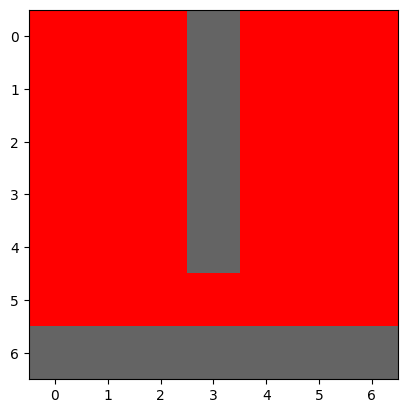

In [34]:
plt.imshow(images[0].permute(1, 2, 0))

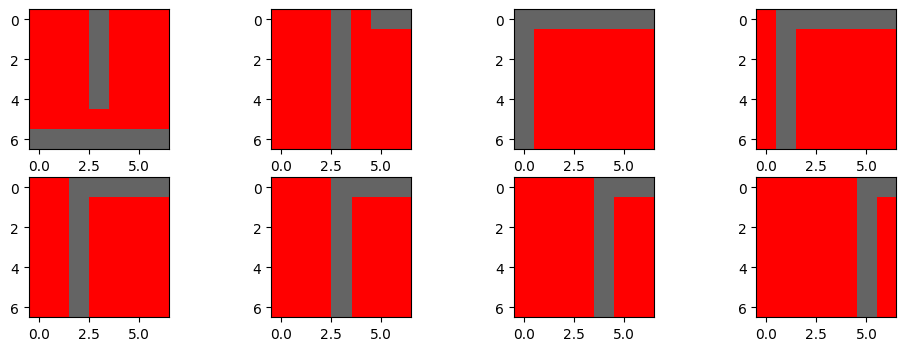

In [35]:
fig, axs = plt.subplots(2, 4, figsize=(12, 4))
for i in range(2):
    for j in range(4):
        axs[i][j].imshow(four_rooms_to_rgb(four_rooms_dataset[0].observations['image'][[i*4+j]])[0].permute(1, 2, 0))

In [36]:
four_rooms_dataset[0].observations['image'][[i]].shape

(1, 7, 7, 3)

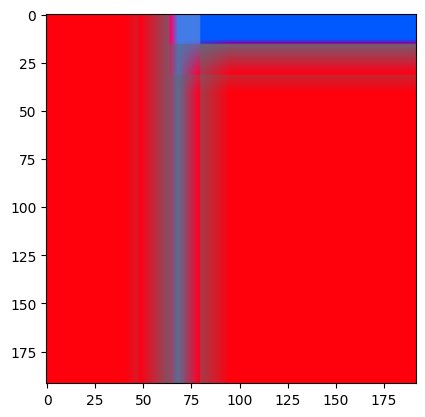

In [37]:
xs, ys = four_rooms_dataset_xf[0]
image = xs['image']
patches = image
plt.imshow(tokenizer.decode_image(patches).permute(0, 2, 3, 1)[4])

In [38]:
image.shape, tokenizer.decode_image(image).shape

(torch.Size([19, 144, 768]), torch.Size([19, 3, 192, 192]))

In [39]:
from PIL import Image
from IPython.display import display, Image as IPythonImage

In [40]:
# Converting them to PIL Images gives us a convenient way to save the images as a GIF.
images = four_rooms_to_rgb(four_rooms_dataset[0].observations['image'])
images = images.permute(0, 2, 3, 1).numpy()
images = [Image.fromarray(image) for image in images]
images[0]

In [41]:
import io
buffer = io.BytesIO()
images[0].save(
    buffer,
    format='GIF',
    save_all=True,
    append_images=images[1:],
    duration=200,
    loop=0,
)
buffer.seek(0)
display(IPythonImage(data=buffer.getvalue(), width=192, height=192))

In [42]:
four_rooms_dataloader = DataLoader(four_rooms_dataset_xf, batch_size=4, collate_fn=generic_collate_fn)

In [43]:
batch = next(iter(four_rooms_dataloader))

In [44]:
batch[0]['mission'].shape

torch.Size([4, 6, 4, 1])

### Visual Question Answering Dataset

In [45]:
vqa_dataset = datasets.load_dataset("eihli/micro-ok-vqa")

In [46]:
def tokenize_vqa(tokenizer, sample):
    question = [tokenizer.encode_text(sample["question"])]
    image = [tokenizer.encode_image(image_transform(pil_to_tensor(sample["image"])))]
    answer = [tokenizer.encode_text(random.choice(sample["answers"])["answer"])]
    question = torch.concat(question)
    image = torch.concat(image)
    answer = torch.concat(answer)
    xs = OrderedDict({
        'question': question[:, :-1],
        'image': image[:, :-1],
        'answer': answer[:, :-1],
    })
    ys = OrderedDict({
        'question': question[:, 1:],
        'image': torch.zeros(xs['image'].size(0), xs['image'].size(1), 1),
        'answer': answer[:, 1:],
    })
    return xs, ys

def vqa_collate_fn(batch, sequence_length=1024):
    sliced = [slice_to_context_window(sequence_length, sample) for sample in batch]
    padded = pad(sliced)
    masked = mask(batch)
    return padded, masked

In [47]:
sample = vqa_dataset['train'][0]

In [48]:
tokens = tokenizer.encode_image(image_transform(pil_to_tensor(sample["image"])))

In [49]:
tokens.shape, tokens

(torch.Size([1, 144, 768]),
 tensor([[[-0.2378, -0.2437, -0.2390,  ...,  0.1854,  0.1832,  0.1849],
          [-0.2446, -0.2466, -0.2453,  ...,  0.2264,  0.2325,  0.2391],
          [-0.1818, -0.1153, -0.0956,  ...,  0.2149,  0.2101,  0.2130],
          ...,
          [ 0.0385,  0.0600,  0.0706,  ...,  0.2237,  0.2288,  0.2367],
          [ 0.0707,  0.0894,  0.1001,  ...,  0.2478,  0.2362,  0.0630],
          [-0.0377, -0.0938, -0.1630,  ...,  0.1883,  0.1839,  0.1875]]]))

In [50]:
vqa_dataset_xf = TransformDataset(vqa_dataset["train"], partial(tokenize_vqa, tokenizer))
vqa_dataloader = DataLoader(vqa_dataset_xf, batch_size=4, collate_fn=generic_collate_fn)

In [51]:
xs, ys, ms = next(iter(vqa_dataloader))

In [52]:
[v.shape for k, v in ys.items()]

[torch.Size([4, 1, 15, 1]),
 torch.Size([4, 1, 143, 1]),
 torch.Size([4, 1, 4, 1])]

In [53]:
sample = vqa_dataset_xf[0]

In [54]:
sample[0]['question'].shape, sample[0]['image'].shape

(torch.Size([1, 11, 1]), torch.Size([1, 143, 768]))

In [55]:
xs, ys = vqa_dataset_xf[0]
(
    xs['question'].shape, 
    xs['image'].shape, 
    tokenizer.decode_text(xs['answer'][0]), 
    tokenizer.decode_text(xs['question'][0])
)

(torch.Size([1, 11, 1]),
 torch.Size([1, 143, 768]),
 'b',
 'What is the hairstyle of the blond called')

In [56]:
xs['answer'][0].tolist()

[[50256], [65], [7086]]

### Shakespeare Dataset

In [57]:
def acquire_shakespeare_dataset():
    temp_dir = tempfile.gettempdir()
    shakespeare_filepath = Path(temp_dir)/"shakespeare.txt"
    if not os.path.exists(shakespeare_filepath):
        data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
        with open(shakespeare_filepath, 'w', encoding='utf-8') as f:
            f.write(requests.get(data_url).text)
    
    with open(shakespeare_filepath, 'r', encoding='utf-8') as f:
        data = f.read()

    # Split the dataset into each character's lines.
    # Continue taking lines until you have at least 250 words in the sample.
    # Add that sample to the dataset.
    characters_lines = re.split(r"\n\s*\n", data.strip())
    MIN_WORDS_PER_BATCH = 250
    sample = [characters_lines[0]]
    num_words_in_sample = len(characters_lines[0].split())
    text_dataset = []
    i = 1
    while i < len(characters_lines):
        if num_words_in_sample > MIN_WORDS_PER_BATCH:
            text_dataset.append("\n\n".join(sample))
            num_words_in_sample -= len(sample[0].split())
            sample = sample[1:]
        sample += [characters_lines[i]]
        num_words_in_sample += len(characters_lines[i].split())
        i += 1

    return text_dataset

In [58]:
shakespeare_dataset = acquire_shakespeare_dataset()

In [59]:
print(f"Number of samples in the dataset: {len(shakespeare_dataset)}")
print(f"Character length of first 3 samples: {[len(x) for x in shakespeare_dataset[:3]]}\n")
print(f"First 80 characters of first sample:\n\n{shakespeare_dataset[0][:80]}")

Number of samples in the dataset: 7184
Character length of first 3 samples: [1632, 1688, 1891]

First 80 characters of first sample:

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.


In [60]:
def tokenize_shakespeare(tokenizer, sample):
    text = torch.concat([tokenizer.encode_text(sample)])
    xs = OrderedDict({
        'text': text[:, :-1],
    })
    ys = OrderedDict({
        'text': text[:, 1:],
    })
    return xs, ys

def shakespeare_collate_fn(batch, sequence_length=1024):
    sliced = [slice_to_context_window(sequence_length, sample) for sample in batch]
    padded = pad(sliced)
    masked = mask(batch)
    return padded, masked

In [61]:
shakespeare_dataset_xf = TransformDataset(shakespeare_dataset, partial(tokenize_shakespeare, tokenizer))
shakespeare_dataloader = DataLoader(shakespeare_dataset_xf, batch_size=4, collate_fn=generic_collate_fn)

In [62]:
batch = [shakespeare_dataset_xf[i] for i in range(4)]
xs, ys, ms = generic_collate_fn(batch)

In [63]:
xs.keys(), xs['text'].shape, ys['text'].shape, ms

(odict_keys(['text']),
 torch.Size([4, 1, 521, 1]),
 torch.Size([4, 1, 521, 1]),
 OrderedDict([('text',
               tensor([[[1., 1., 1.,  ..., 0., 0., 0.]],
               
                       [[1., 1., 1.,  ..., 0., 0., 0.]],
               
                       [[1., 1., 1.,  ..., 1., 1., 1.]],
               
                       [[1., 1., 1.,  ..., 0., 0., 0.]]]))]))

In [64]:
ms['text'].sum(dim=2)

tensor([[453.],
        [471.],
        [521.],
        [512.]])

## Embedding and sequencing

It makes sense to talk about these two together.

TODO: Finish

### [Embedding § 2.2](https://arxiv.org/pdf/2205.06175#page=3)

We only really need two embedding modules.

- A ResNetV2 module for images
- A `torch.nn.Embedding` module for text, discrete, and continuous

In [66]:
EMBEDDING_DIMS = 512
image_embedding = ResNetV2(layers=[3, 4, 6, 3], num_classes=EMBEDDING_DIMS)
lookup_embedding = torch.nn.Embedding(tokenizer.vocab_size, EMBEDDING_DIMS)

In [67]:
xs, ys, ms = next(iter(four_rooms_dataloader))

In [68]:
image_tokens = xs['image']
image_tokens.shape

torch.Size([4, 6, 144, 768])

In [69]:
B, E, T, C = image_tokens.shape
patch_size=16

In [70]:
patch_tokens = image_tokens.view(B*E*T, 3, patch_size, patch_size)
patch_embeddings = image_embedding(patch_tokens).view(B, E, T, -1)

In [71]:
patch_tokens.shape

torch.Size([3456, 3, 16, 16])

In [72]:
patch_embeddings.shape

torch.Size([4, 6, 144, 512])

In [73]:
mission_tokens = xs['mission']
mission_tokens.shape

torch.Size([4, 6, 4, 1])

In [74]:
B, E, T, C = mission_tokens.shape

In [75]:
mission_tokens.view(B*E*T, -1).shape

torch.Size([96, 1])

In [76]:
mission_embeddings = lookup_embedding(mission_tokens).view(B, E, T, -1)
mission_embeddings.shape

torch.Size([4, 6, 4, 512])

### Sequence Ordering [§ 2.1](https://arxiv.org/pdf/2205.06175#page=3)

After converting data into tokens, we use the following canonical sequence ordering.

- Text tokens in the same order as the raw input text.
- Image patch tokens in raster order.
- Nested structures in lexicographical order by key.
- Agent timesteps as observation tokens followed by a separator, then action tokens.
- Agent episodes as timesteps in time order.

In [77]:
from typing import Callable
@dataclass
class Embedder:
    tokenizer: Tokenizer
    lookup_embedding: Callable
    image_embedding: Callable

    def embed(self, data):
        B, E, T, C = data.shape
        if self.tokenizer.is_image(data):
            #                                         (C,  P,  P)
            return self.image_embedding(data.view(B*E*T, 3, 16, 16)).view(B, E, T, -1)
        else:
            return self.lookup_embedding(data.view(B*E*T)).view(B, E, T, -1)

def sequence(embedder, xs, ys=None, ms=None, sequence_length=1024, pad=True):
    embeddings = torch.concat([embedder.embed(v) for k, v in xs.items()], dim=2)
    B, E, T, C = embeddings.shape
    embeddings = embeddings.view(B, E*T, C)
    if ys is not None:
        targets = torch.concat([v for _, v in ys.items()], dim=2)
        masks = torch.concat([v for _, v in ms.items()], dim=2)
        targets = targets.view(B, E*T)
        masks = masks.view(B, E*T)
        if pad:
            return (
                F.pad(embeddings, (0, 0, 0, sequence_length - embeddings.size(1), 0, 0), value=0),
                F.pad(targets, (0, sequence_length - embeddings.size(1), 0, 0), value=0).to(torch.long),
                F.pad(masks, (0, sequence_length - embeddings.size(1), 0, 0), value=0),
            )
        else:
            return embeddings, targets, masks
    else:
        if pad:
            return F.pad(embeddings, (0, 0, 0, sequence_length - embeddings.size(1), 0, 0), value=0)
        else:
            return embeddings

In [78]:
embedder = Embedder(tokenizer, lookup_embedding, image_embedding)

In [79]:
mission_tokens.shape

torch.Size([4, 6, 4, 1])

In [80]:
embedder.embed(mission_tokens).shape

torch.Size([4, 6, 4, 512])

In [81]:
embedder.embed(image_tokens).shape

torch.Size([4, 6, 144, 512])

In [82]:
xs, ys, ms = next(iter(four_rooms_dataloader))

In [83]:
xs['mission'].shape, ms['mission'].shape

(torch.Size([4, 6, 4, 1]), torch.Size([4, 6, 4]))

In [84]:
embeddings = torch.concat([embedder.embed(v) for k, v in xs.items()], dim=2)

In [85]:
embeddings.shape

torch.Size([4, 6, 152, 512])

In [86]:
torch.concat([v for v in ms.values()], dim=2).shape

torch.Size([4, 6, 152])

In [87]:
B, E, T, C = embeddings.shape
embeddings.view(B, E*T, C).shape

torch.Size([4, 912, 512])

In [88]:
ms['image'].shape

torch.Size([4, 6, 144])

In [89]:
type(xs), type(ms)

(__main__.OrderedDict, __main__.OrderedDict)

In [90]:
xs, ys, ms = sequence(embedder, xs, ys, ms)

In [91]:
xs.shape, ys.shape, ms.shape

(torch.Size([4, 1024, 512]), torch.Size([4, 1024]), torch.Size([4, 1024]))

In [92]:
xs, ys, ms = next(iter(shakespeare_dataloader))

In [93]:
xs, ys, ms = sequence(embedder, xs, ys, ms)

In [94]:
xs.shape, ys.shape, ms.shape

(torch.Size([4, 1024, 512]), torch.Size([4, 1024]), torch.Size([4, 1024]))

## Continuous Dataset

In [95]:
pointmaze_dataset = minari.load_dataset('D4RL/pointmaze/open-v2', download=True)

In [96]:
pointmaze_dataset[0].observations.keys()

dict_keys(['achieved_goal', 'desired_goal', 'observation'])

In [97]:
def tokenize_pointmaze(tokenizer, sample):
    goal_tokens = [tokenizer.encode_continuous(goal) for goal in sample.observations["desired_goal"][:-1]]
    action_tokens = [tokenizer.encode_continuous(action, is_action=True) for action in sample.actions]
    goal = torch.concat(goal_tokens)
    action = torch.concat(action_tokens)
    xs = OrderedDict({
        'goal': goal[:, :-1],
        'action': action[:, :-1], 
    })
    ys = OrderedDict({
        'goal': goal[:, 1:],
        'action': action[:, 1:],
    })
    return xs, ys

In [98]:
pointmaze_dataset_xf = TransformDataset(pointmaze_dataset, partial(tokenize_pointmaze, tokenizer))
pointmaze_dataloader = DataLoader(pointmaze_dataset_xf, batch_size=4, collate_fn=generic_collate_fn)

In [99]:
it = iter(pointmaze_dataloader)

In [100]:
xs, ys = pointmaze_dataset_xf[0]
xs['goal'].shape, xs['action'].shape

(torch.Size([45, 3, 1]), torch.Size([45, 3, 1]))

In [101]:
xs, ys, ms = next(it)

In [102]:
[v.shape for v in xs.values()]

[torch.Size([4, 102, 3, 1]), torch.Size([4, 102, 3, 1])]

In [103]:
batch = [pointmaze_dataset_xf[i] for i in range(4)]

In [104]:
batch[0][0].keys()

odict_keys(['goal', 'action'])

In [105]:
batch = generic_collate_fn(batch)

In [106]:
shakespeare_dataset_xf = TransformDataset(shakespeare_dataset, partial(tokenize_shakespeare, tokenizer))
shakespeare_dataloader = DataLoader(shakespeare_dataset_xf, batch_size=4, collate_fn=generic_collate_fn)

In [107]:
xs, ys, ms = next(iter(shakespeare_dataloader))

In [108]:
xs['text'].shape, ms

(torch.Size([4, 1, 521, 1]),
 OrderedDict([('text',
               tensor([[[1., 1., 1.,  ..., 0., 0., 0.]],
               
                       [[1., 1., 1.,  ..., 0., 0., 0.]],
               
                       [[1., 1., 1.,  ..., 1., 1., 1.]],
               
                       [[1., 1., 1.,  ..., 0., 0., 0.]]]))]))

# Training

In [109]:
BATCH_SIZE=4
SEQUENCE_LENGTH=1024

In [110]:
def infinite_dataloader(fn):
    it = iter(fn())
    while True:
        try:
            yield next(it)
        except StopIteration:
            it = iter(fn())

In [111]:
dataloaders = [
    infinite_dataloader(partial(DataLoader, four_rooms_dataset_xf, batch_size=BATCH_SIZE, collate_fn=generic_collate_fn)),
    infinite_dataloader(partial(DataLoader, shakespeare_dataset_xf, batch_size=BATCH_SIZE, collate_fn=generic_collate_fn)),
    infinite_dataloader(partial(DataLoader, vqa_dataset_xf, batch_size=BATCH_SIZE, collate_fn=generic_collate_fn)),
]

In [112]:
dataloader = cycle(dataloaders)
get_batch = lambda: next(next(dataloader))

In [113]:
xs, ys, ms = get_batch()

In [114]:
xs.keys()

odict_keys(['mission', 'direction', 'image', 'action'])

In [115]:
xs['mission'][0][0], ys['mission'][0][0], ms['mission'][0][0]

(tensor([[50256],
         [16250],
         [  262],
         [ 3061]]),
 tensor([[16250],
         [  262],
         [ 3061],
         [50256]]),
 tensor([1., 1., 1., 1.]))

In [116]:
xs, ys, ms = sequence(embedder, xs, ys, ms)

In [117]:
xs.shape, ys.shape, ms.shape, ys, ms

(torch.Size([4, 1024, 512]),
 torch.Size([4, 1024]),
 torch.Size([4, 1024]),
 tensor([[16250,   262,  3061,  ...,     0,     0,     0],
         [16250,   262,  3061,  ...,     0,     0,     0],
         [16250,   262,  3061,  ...,     0,     0,     0],
         [16250,   262,  3061,  ...,     0,     0,     0]]),
 tensor([[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]]))

In [118]:
@dataclass
class MiniGatoConfig:
    device = 'cuda'
    embedding_dim: int
    sequence_length: int
    vocab_size: int
    tokenizer: Tokenizer
    transformer_config: GPTConfig

def init_default_config(model_args: GPTConfig) -> MiniGatoConfig:
    text_tokenizer = tiktoken.get_encoding("r50k_base")
    tokenizer = Tokenizer(text_tokenizer)
    transformer_config = GPTConfig(**model_args)
    return MiniGatoConfig(
        embedding_dim=transformer_config.n_embd,
        sequence_length=transformer_config.block_size,
        vocab_size=tokenizer.vocab_size,
        tokenizer=tokenizer,
        transformer_config=transformer_config,
    )

model_args = dict(n_layer=4, n_head=4, n_embd=512, block_size=1024,
                  bias=False, vocab_size=tokenizer.vocab_size, dropout=0.0) # start with model_args from command line    
default_config = init_default_config(model_args)

class MiniGato(torch.nn.Module):
    def __init__(self, config: MiniGatoConfig=default_config):
        super().__init__()
        self.config = config
        self.device = self.config.device
        self.sequence_length = self.config.sequence_length
        self.lookup_embedding = torch.nn.Embedding(self.config.vocab_size, self.config.embedding_dim)
        self.image_embedding = ResNetV2(layers=[3, 4, 6, 3], num_classes=self.config.embedding_dim)
        self.embedder = Embedder(self.config.tokenizer, self.lookup_embedding, self.image_embedding)
        # TODO:
        # Since we're doing our own embedding, we need to handle our own
        # position embedding.
        self.transformer = GPT(self.config.transformer_config)
        self.lm_head = torch.nn.Linear(self.transformer.config.n_embd, self.config.vocab_size)     

    def forward(self, xs, ys=None, ms=None, pad=True):
        if ys is not None:
            seqxs, seqys, seqms = sequence(model.embedder, xs, ys, ms, pad=pad)
            out = model.transformer(emb=seqxs)
            logits = model.lm_head(out)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), seqys.view(-1), reduction='none')
            loss = loss * seqms.view(-1)
            loss = loss.sum() / seqms.sum()
        else:
            seqxs = sequence(model.embedder, xs, pad=pad)     
            out = self.transformer(emb=seqxs)
            logits = self.lm_head(out)
            loss = None        
        return logits, loss

In [119]:
class MiniGatoTrainer:
    def __init__(self, model, optimizer, dataloaders, device='cuda', scheduler=None, lr=3e-4, num_iterations=10):
        self.model = model
        self.device = model.device
        self.optimizer = optimizer
        self.dataloaders = dataloaders
        self.scheduler = scheduler
        self.dl_it = cycle(dataloaders)
        self.losses = []
        self.num_iterations = num_iterations
        self.lr = lr

    def train(self):
        self.model.train()
        for i in tqdm(range(self.num_iterations)):
            dl = next(self.dl_it)
            xs, ys, ms = next(dl)
            xs, ys, ms = xs.to(self.device), ys.to(self.device), ms.to(self.device)
            optimizer.zero_grad()
            logits, loss = self.model(xs, ys, ms)
            self.losses.append(loss.item())
            loss.backward()
            if self.scheduler:
                self.scheduler.step()
            self.optimizer.step()

In [120]:
device = 'cuda'

In [121]:
model = MiniGato(default_config).to(device)

number of parameters: 38.84M


In [122]:
NUM_ITERATIONS = 100
LR = 1e-3
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_ITERATIONS, eta_min=1e-6)
trainer = MiniGatoTrainer(
    model,
    optimizer,
    dataloaders,
    num_iterations=NUM_ITERATIONS,
    lr=1e-3,
)

In [123]:
next(trainer.dl_it)
dl = next(trainer.dl_it)  # Grab the Shakespeare DataLoader.
xs, ys, ms = next(dl)
xs, ys, ms = xs.to(trainer.device), ys.to(trainer.device), ms.to(trainer.device)

In [124]:
model.train();

In [126]:
optimizer.zero_grad()
seqxs, seqys, seqms = sequence(model.embedder, xs, ys, ms)
out = model.transformer(emb=seqxs)
logits = model.lm_head(out)
loss = F.cross_entropy(logits.view(-1, logits.size(-1)), seqys.view(-1), reduction='none')
masked_loss = loss * seqms.view(-1)
mean_loss = masked_loss.sum() / seqms.sum()
probs = logits.softmax(dim=2)

In [128]:
mean_loss

tensor(10.9922, device='cuda:0', grad_fn=<DivBackward0>)

In [129]:
mean_loss.backward()

In [257]:
xs['text'][1][:, :10], tokenizer.decode_text(xs['text'][1][:, :10]), text_tokenizer.decode([5248])

(tensor([[[50256],
          [ 3237],
          [   25],
          [  198],
          [ 5248],
          [  461],
          [   11],
          [ 2740],
          [   13],
          [  198]]], device='cuda:0'),
 'All:\nSpeak, speak.',
 'Spe')

In [263]:
logits[1][3][5248]  # This is the token we want to predict.

tensor(12.1702, device='cuda:0', grad_fn=<SelectBackward0>)

In [264]:
logits[1, 3, :].argmax()

tensor(5248, device='cuda:0')

In [401]:
for _ in range(100):
    optimizer.zero_grad()
    seqxs, seqys, seqms = sequence(model.embedder, xs, ys, ms)
    out = model.transformer(emb=seqxs)
    logits = model.lm_head(out)
    loss = F.cross_entropy(logits.view(-1, logits.size(-1)), seqys.view(-1), reduction='none')
    with torch.no_grad():
        probs = logits.softmax(dim=2)
        prob = probs[1][3][5248].item()
    masked_loss = loss * seqms.view(-1)
    mean_loss = masked_loss.sum() / seqms.sum()
    mean_loss.backward()
    optimizer.step()
    scheduler.step()
    mean_loss.item(), prob  # This is the token we want to predict.
with torch.no_grad():
    print(mean_loss.item(), probs[1, 3].topk(5))

0.1163628026843071 torch.return_types.topk(
values=tensor([0.5528, 0.4280, 0.0047, 0.0035, 0.0029], device='cuda:0'),
indices=tensor([5248, 4965, 5962, 1639, 8421], device='cuda:0'))


In [402]:
with torch.no_grad():
    print(probs[1, 3].topk(5))

torch.return_types.topk(
values=tensor([0.5528, 0.4280, 0.0047, 0.0035, 0.0029], device='cuda:0'),
indices=tensor([5248, 4965, 5962, 1639, 8421], device='cuda:0'))


In [303]:
probs[1, 3].argmax()

tensor(4965, device='cuda:0')

In [301]:
probs[1, :15].argmax(dim=1).shape

torch.Size([15])

In [371]:
with torch.no_grad():
    print(text_tokenizer.decode(probs[1, :15].argmax(dim=1).tolist()))

All:
Speak, speak.


 Citizen:
You


In [135]:
for _ in tqdm(range(20)):
    optimizer.zero_grad()
    seqxs, seqys, seqms = sequence(model.embedder, xs, ys, ms)
    out = model.transformer(emb=seqxs)
    logits = model.lm_head(out)
    loss = F.cross_entropy(logits.view(-1, logits.size(-1)), seqys.view(-1), reduction='none')
    masked_loss = loss * seqms.view(-1)
    mean_loss = masked_loss.sum() / seqms.sum()
    mean_loss.backward()
    optimizer.step()
    scheduler.step()    

  0%|          | 0/20 [00:00<?, ?it/s]

In [136]:
mean_loss

tensor(1.1125, device='cuda:0', grad_fn=<DivBackward0>)

In [137]:
scaled = logits / 1
counts = (scaled - scaled.max(dim=1, keepdims=True).values).exp()
probs = counts / counts.sum(dim=1, keepdims=True)

In [138]:
probs[0, 0, 0]

tensor(9.0953e-05, device='cuda:0', grad_fn=<SelectBackward0>)

In [139]:
logits.softmax(dim=1)[0, 0, 0]

tensor(9.0953e-05, device='cuda:0', grad_fn=<SelectBackward0>)

In [140]:
probs[0, 0, 0]

tensor(9.0953e-05, device='cuda:0', grad_fn=<SelectBackward0>)

In [418]:
model.eval()
text = "First Citizen:\n"
tokens = tokenizer.encode_text(text)
xs, ys = OrderedDict(text=tokens[:, :-1]), OrderedDict(text=tokens[:, 1:])
xs, ys, ms = generic_collate_fn([[xs, ys]])
next_word_token = None
i = 0
xs, ys, ms = [x.to(device) for x in [xs, ys, ms]]

In [419]:
logits, loss = model(xs, pad=False)

In [420]:
temp = 0.4
scaled_logits = logits / temp
probs = scaled_logits.softmax(dim=2)

In [421]:
next_word_token = torch.multinomial(probs.squeeze()[-1], num_samples=1)
next_word = tokenizer.decode_text(torch.tensor([0, *next_word_token, 0]))
text += next_word
text

'First Citizen:\nBefore'

In [497]:
tokens = tokenizer.encode_text(text)
xs, ys = OrderedDict(text=tokens[:, :-1]), OrderedDict(text=tokens[:, 1:])
xs, ys, ms = generic_collate_fn([[xs, ys]])
next_word_token = None
i = 0
xs, ys, ms = [x.to(device) for x in [xs, ys, ms]]
logits, loss = model(xs, pad=False)
temp = 0.5
scaled_logits = logits / temp
probs = scaled_logits.softmax(dim=2)
next_word_token = torch.multinomial(probs.squeeze()[-1], num_samples=1)
next_word = tokenizer.decode_text(torch.tensor([0, *next_word_token, 0]))
text += next_word
text

'First Citizen:\nBefore we proceed any further, hear me speak.\nAll:\nSpeak, speak.\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\n him, hear me speak.\nAll:\nResolved. resolved.\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\nAll:'

In [264]:
trainer.train()

  0%|          | 0/100 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 802.00 MiB. GPU 0 has a total capacity of 15.71 GiB of which 675.56 MiB is free. Including non-PyTorch memory, this process has 15.03 GiB memory in use. Of the allocated memory 13.97 GiB is allocated by PyTorch, and 922.67 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

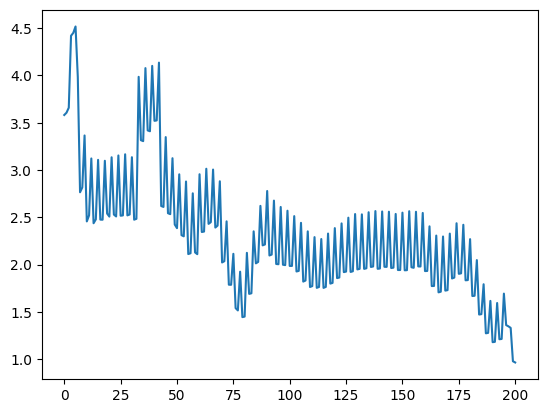

In [223]:
window_size = 10
data = torch.tensor(trainer.losses)
moving_avg = torch.conv1d(
    data.view(1, 1, data.size(0)), 
    torch.ones(1, 1, window_size) / window_size, padding=window_size//2
).squeeze()
plt.plot(moving_avg)

In [251]:
model.eval()
text = "First Citizen:"
tokens = tokenizer.encode_text(text)
xs, ys = OrderedDict(text=tokens[:, :-1]), OrderedDict(text=tokens[:, 1:])
xs, ys, ms = generic_collate_fn([[xs, ys]])
next_word_token = None
i = 0
xs, ys, ms = [x.to(device) for x in [xs, ys, ms]]

In [252]:
sq = sequence(model.embedder, xs, pad=False)

In [253]:
sq.shape

torch.Size([1, 4, 768])

In [254]:
logits, loss = model(xs, pad=False)

In [255]:
temp = 0.3
scaled_logits = logits / temp
probs = scaled_logits.softmax(dim=2)

In [256]:
probs.shape

torch.Size([1, 4, 51281])

In [257]:
torch.multinomial(probs.squeeze(), num_samples=1)

tensor([[11956],
        [49924],
        [14874],
        [ 7581]], device='cuda:0')

In [258]:
next_word_token = torch.multinomial(probs.squeeze()[-1], num_samples=1)
next_word = tokenizer.decode_text(torch.tensor([0, *next_word_token, 0]))
text += next_word
text

'First Citizen:FUN'

In [259]:
probs.topk(5)

torch.return_types.topk(
values=tensor([[[0.0106, 0.0074, 0.0046, 0.0028, 0.0028],
         [0.0197, 0.0144, 0.0077, 0.0050, 0.0047],
         [0.0062, 0.0049, 0.0048, 0.0046, 0.0043],
         [0.0171, 0.0095, 0.0074, 0.0068, 0.0049]]], device='cuda:0',
       grad_fn=<TopkBackward0>),
indices=tensor([[[31628,  2994, 23469, 31563, 41998],
         [49924, 42126,  8270, 25586, 10012],
         [13688,  2248, 41002, 17299,  6112],
         [43737, 38207, 30615, 31322, 40001]]], device='cuda:0'))

In [221]:
def eval_text():
    model.eval()
    text = "First Citizen:"
    next_word_token = None
    i = 0
    while i < 20 and next_word_token != __text_tokenizer.eos_token:
        with torch.no_grad():
            tokens = tokenizer.encode_text(text)
            x = tokens.embed(model.embedder).to(device)
            pr, ys, ms = model([tokens])
            heat = 0.8
            prh = pr / heat
            sm = prh.softmax(dim=2)
            last_index = ms.nonzero()[-1].cpu()[1]
            next_word_probs = sm[0, last_index-1]
            next_word_token = torch.multinomial(next_word_probs, num_samples=1)
            next_word = __text_tokenizer.decode(next_word_token)
            text += next_word
        i += 1
    return text